# Evaluating Synthetic Data

This is a quick example to show how to use the evaluation metrics in this library on your synthetic data.

Our current repo is still very much work-in-progress, so you may run into some errors. Also, there will likely be some significant changes to the code structure in the future. We aim to update these notebooks at a later stage.

# Environment

## Library Imports

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
from itertools import product

## Jupyter-specific Imports and Settings

In [2]:
# set printing options
np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    get_ipython().run_line_magic('load_ext', 'autoreload')

get_ipython().run_line_magic('autoreload', '2')
from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import local libraries

In [4]:
from synthesis.evaluation.metrics import MarginalComparison, AssociationsComparison
from synthesis.evaluation.efficacy import ClassifierComparison
from synthesis.evaluation._base import BaseMetric
from synthesis.evaluation.evaluator import DEFAULT_METRICS, SyntheticDataEvaluator

# Load and Preprocess datasets

Load the original and synthetic datasets you created.

In [5]:
columns = ['age', 'workclass', 'education', 'marital-status', 'occupation', 'relationship', 
           'race', 'sex', 'capital-gain', 'hours-per-week', 'native-country', 'income']
df_original = pd.read_csv('examples/data/original/adult.csv', usecols=columns)
df_original.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country,income
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,2174,40,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,13,United-States,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,40,United-States,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,40,United-States,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,40,Cuba,<=50K


In [6]:
df_synthetic = pd.read_csv('examples/data/synthetic/adult_pb_1eps.csv', usecols=columns)
df_synthetic.head()

,age,workclass,education,marital-status,occupation,relationship,race,sex,capital-gain,hours-per-week,native-country,income
0,19,State-gov,Bachelors,Divorced,Other-service,Not-in-family,White,Female,0,72,United-States,<=50K
1,24,Private,Some-college,Never-married,Craft-repair,Not-in-family,White,Male,0,20,United-States,<=50K
2,29,Private,Some-college,Separated,Adm-clerical,Unmarried,White,Female,99999,70,United-States,<=50K
3,18,Private,9th,Divorced,Exec-managerial,Not-in-family,White,Male,0,40,United-States,<=50K
4,38,Self-emp-not-inc,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,50,United-States,>50K


# Evaluate

When comparing synthetic dataset to an original, we can run metrics individually by fitting them on the original and synthetic data. 

Subsequently we can run the methods score() and plot().

0.06298057544931891

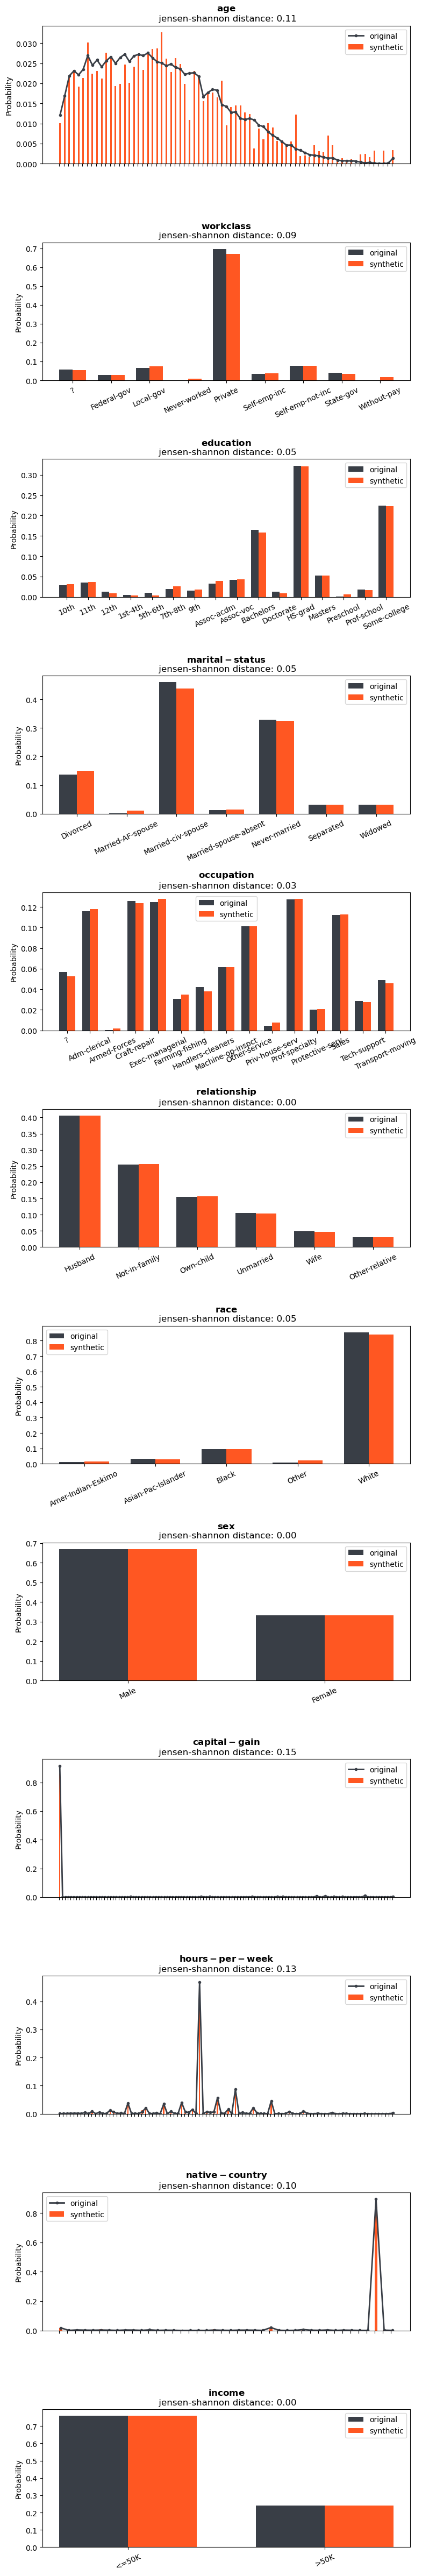

In [7]:
marginal_comparison= MarginalComparison().fit(df_original, df_synthetic)
marginal_comparison.score()
marginal_comparison.plot()

Or we can fit multiple metrics at the same time using the SyntheticDataEvaluator.

In [8]:
synth_eval = SyntheticDataEvaluator()
synth_eval.fit(df_original, df_synthetic)

After fitting you can use the score and plotting functions to see the results.

In [9]:
synth_eval.score()

{'average_js_distance': 0.06298057544931891,
 'pairwise_correlation_distance': 1.3089697266301301}

SyntheticEvaluator uses the following default metrics. 

In [10]:
DEFAULT_METRICS

{'average_js_distance': <synthesis.evaluation.metrics.MarginalComparison at 0x14e484760>,
 'pairwise_correlation_distance': <synthesis.evaluation.metrics.AssociationsComparison at 0x14e484700>}

You can remove or add additional metrics and specify these at initialisation using a dictionary as seen below.

Custom metrics should inherent from synthesis.evaluation._base.BaseMetric and should have at least have a fit and score function (plot is optional).

In [11]:
class CustomMetric(BaseMetric):
    """Example metric that checks whether both dataset have same length"""

    def fit(self, data_original, data_synthetic):
        self.stats_original_ = data_original.shape[0]
        self.stats_synthetic_ = data_synthetic.shape[0]
    
    def score(self):
        return self.stats_original_ == self.stats_synthetic_
    
    def plot(self):
        pass

In [12]:
custom_metrics = {
    'same_length': CustomMetric(),
    'pairwise_correlation_distance': AssociationsComparison()
}

{'same_length': True, 'pairwise_correlation_distance': 1.3089697266301301}

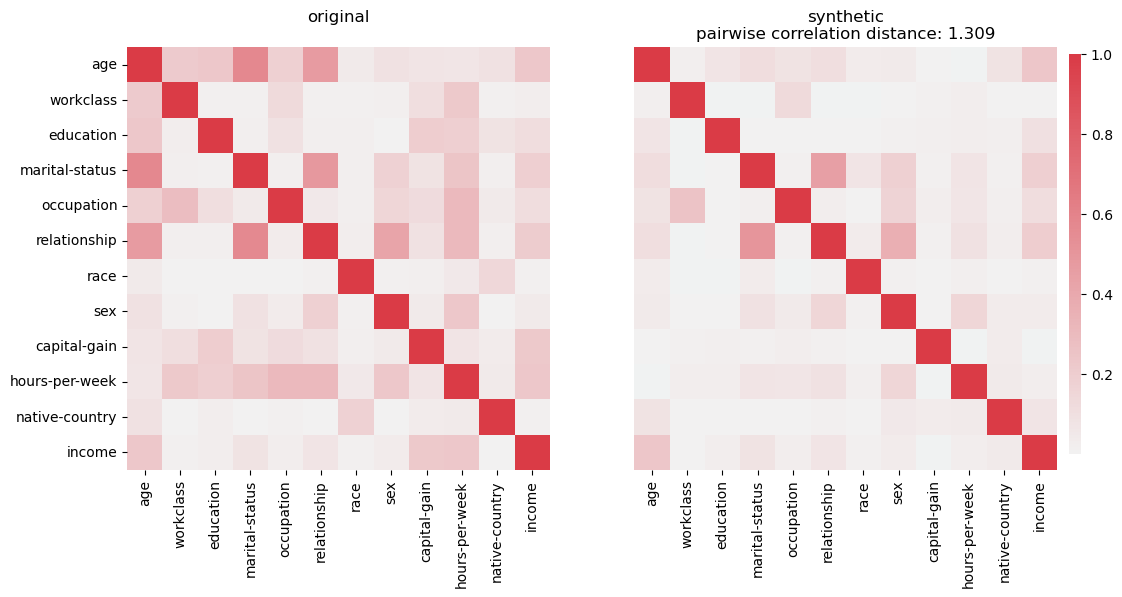

In [13]:
se_custom = SyntheticDataEvaluator(metrics=custom_metrics)
se_custom.fit(df_original, df_synthetic)
se_custom.score()
se_custom.plot()

Note we did not implement a plot method for our custom metric, hence no plot is shown for this custom metric.

# Evaluating Efficacy

We support also metrics that evaluate the efficacy of synthetic dataset, like machine learning or survival analysis.

These can be run standalone. These are currently not supported by the SyntheticEvaluator class (will be adapted later).

In [14]:
df_original['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)

In [16]:
# need to convert to target categories to 0 and 1 prior to fitting
df_original['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)
df_synthetic['income'].replace({'<=50K': 0, '>50K': 1}, inplace=True)

cc = ClassifierComparison(y_column='income', random_state=42, n_jobs=4)
cc.fit(df_original, df_synthetic)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Fitting 3 folds for each of 18 candidates, totalling 54 fits


We unfortunately didn't create a test dataset before generating the data. Hence, for this example we use the original dataset as the test data (not advised - will be adapted later).

In [17]:
df_original_test = df_original.copy()
cc.score(df_original_test)

{'score_original': 0.6413331398929801, 'score_synthetic': 0.6007539741017078}

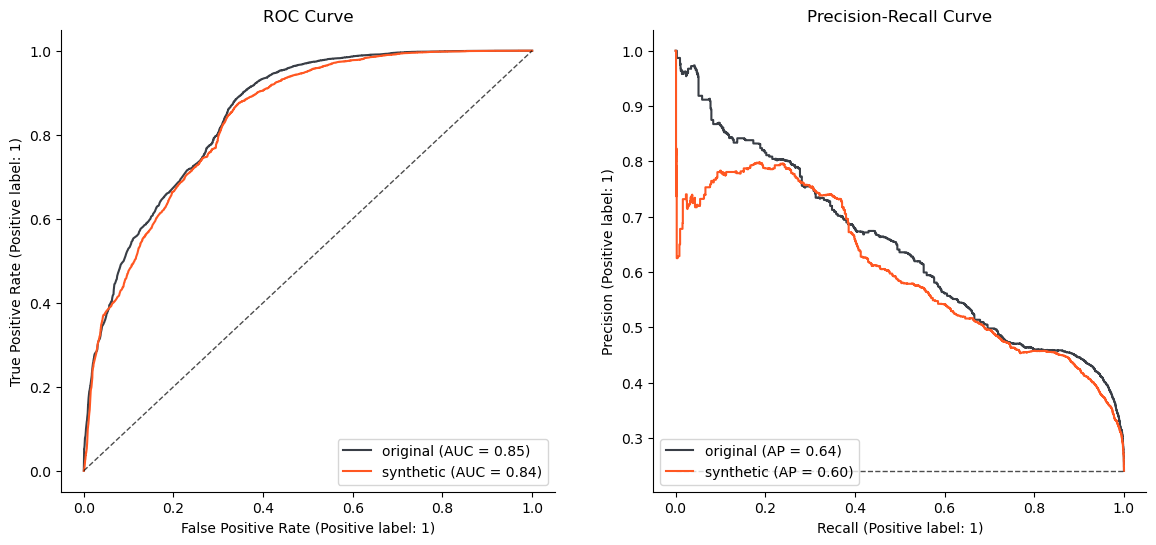

In [18]:
cc.plot(df_original_test)